# 2nd Level Model Structure: Reactive Stage

In [1]:
import sys
import os
import pickle
sys.path.append(os.path.abspath('..'))
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from pyomo import environ as pe
from global_sets.component import m
from utility.display_utility import trans_product_mole, trans_product_mass
from utility.model_utility import add_dual, update_dual, check_DOF

# stage construction rules
from physics.kinetics_bounded import kinetic_block_rule
from physics.energy_bounded import energy_block_rule
from physics.VLE_bounded_MPCC_T import VLE_block_rule
from physics.MPCC_T import dew_block_rule

model = pe.ConcreteModel()

# Global Sets (Inlet / Outlet)

In [3]:
model.inlet = pe.Set(initialize=['in'])
model.outlet = pe.Set(initialize=['out','P'])
model.stream = model.inlet | model.outlet

# Global Variables

In [4]:
# Tray Inlet/Outlet Variable
model.x_ = pe.Var(model.inlet,m.COMP_TOTAL,within=pe.NonNegativeReals)
model.y_ = pe.Var(model.inlet,m.COMP_TOTAL,within=pe.NonNegativeReals)
model.x = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals)
model.y = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals)
model.z = pe.Var(m.COMP_FEED,within=pe.NonNegativeReals)

model.L = pe.Var(model.stream,within=pe.NonNegativeReals)
model.V = pe.Var(model.stream,within=pe.NonNegativeReals)
model.F = pe.Var(within=pe.NonNegativeReals)

model.H_L_ = pe.Var(model.inlet,within=pe.Reals)
model.H_V_ = pe.Var(model.inlet,within=pe.Reals)
model.H_L = pe.Var(within=pe.Reals)
model.H_V = pe.Var(within=pe.Reals)
model.H_F = pe.Var(within=pe.Reals)

# State Variable
model.T = pe.Var(within=pe.NonNegativeReals,bounds=(170,300+273.15)) # K
model.T_F = pe.Var(within=pe.NonNegativeReals) # K
model.P = pe.Var(within=pe.NonNegativeReals,bounds=(10,30)) # Bar

model.f_V = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals,initialize=1e-20)
model.f_L = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals,initialize=1e-20)

model.cat = pe.Var(within=pe.NonNegativeReals,initialize=3000) # kg
model.Q_main = pe.Var(within=pe.Reals) # MW
model.r_total_comp = pe.Var(m.COMP_TOTAL,within=pe.Reals) # kmol/s

# Construct Individual Blocks

In [5]:
model.kinetics_block = pe.Block(rule=kinetic_block_rule)

> Importing Kinetics Blocks......
> Adding the following local variable:
--------------------------------------------------
| kinetics_block.k_FT
| kinetics_block.r_FT_total
| kinetics_block.g0_FT
| kinetics_block.alpha
| kinetics_block.r_FT_cnum
| kinetics_block.r_FT_comp
| kinetics_block.k_WGS
| kinetics_block.Ke_WGS
| kinetics_block.r_WGS
| kinetics_block.r_WGS_comp
--------------------------------------------------



In [6]:
model.energy_block = pe.Block(rule=energy_block_rule)

> Importing Energy Blocks......
> Adding the following local variable:
--------------------------------------------------
| energy_block.dH_F
| energy_block.dH_V
| energy_block.dH_L
| energy_block.dH_vap
--------------------------------------------------



In [7]:
model.VLE_block = pe.Block(rule=VLE_block_rule)

> Importing VLE Blocks......
> Adding the following local variable:
--------------------------------------------------
| VLE_block.T_VLE
| VLE_block.n_ave
| VLE_block.n_ave_cal
| VLE_block.Hen
| VLE_block.Hen0
| VLE_block.gamma
| VLE_block.P_sat
| VLE_block.P_sat_Y
| VLE_block.P_sat_dY_inf
| VLE_block.P_sat_dY0
| VLE_block.Hen_ref
| VLE_block.Hen0_ref
| VLE_block.gamma_ref
| VLE_block.V_L
| VLE_block.V_L_dY_inf
| VLE_block.V_L_dY0
| VLE_block.poynting
--------------------------------------------------



# Standard MESH Equations

## Mass Balance

\begin{equation}
Fz_{i}+\sum_{s\in{inlet}}L_{s}x'_{i,s}+\sum_{s\in{inlet}}V_{s}y'_{i,s}-\sum_{s\in{outlet}}L_{s}x_{i,s}-\sum_{s\in{ouelet}}V_{s}y_{i,s}+R_{i} = 0 \\
i = 1,...NC
\end{equation}

In [8]:
def mass_balance_main_rule(model,i):
    if i in m.COMP_FEED:
        return model.F*model.z[i] + sum(model.L[s]*model.x_[s,i] + model.V[s]*model.y_[s,i] for s in model.inlet)\
        + model.r_total_comp[i] - sum(model.L[s]*model.x[i] + model.V[s]*model.y[i] for s in model.outlet) == 0
    else:
        return sum(model.L[s]*model.x_[s,i] + model.V[s]*model.y_[s,i] for s in model.inlet)\
        + model.r_total_comp[i] - sum(model.L[s]*model.x[i] + model.V[s]*model.y[i] for s in model.outlet) == 0
model.mass_balance_main_con = pe.Constraint(m.COMP_TOTAL,rule=mass_balance_main_rule)

## Equilibrium

\begin{align}
&f_{i,V} = f_{i,L} \\
&i = 1,...NC
\end{align}

In [9]:
def VL_equil_rule(model,i):
    return model.f_V[i] == model.f_L[i]
model.VL_equil_con = pe.Constraint(m.COMP_TOTAL,rule=VL_equil_rule)

## MPCC: T

In [10]:
model.MPCC = pe.Block(rule=dew_block_rule)

> Importing dew Blocks......
> Adding the following local variable:
------------------------------------
| MPCC.x
| MPCC.y
| MPCC.T
| MPCC.P
| MPCC.f_V
| MPCC.f_L
| MPCC.beta
| MPCC.s_L
| MPCC.s_V
| MPCC.epi
------------------------------------

> Importing VLE Blocks......
> Adding the following local variable:
--------------------------------------------------
| MPCC.VLE_block.n_ave
| MPCC.VLE_block.n_ave_cal
| MPCC.VLE_block.Hen
| MPCC.VLE_block.Hen0
| MPCC.VLE_block.gamma
| MPCC.VLE_block.P_sat
| MPCC.VLE_block.P_sat_Y
| MPCC.VLE_block.P_sat_dY_inf
| MPCC.VLE_block.P_sat_dY0
| MPCC.VLE_block.Hen_ref
| MPCC.VLE_block.Hen0_ref
| MPCC.VLE_block.gamma_ref
| MPCC.VLE_block.V_L
| MPCC.VLE_block.V_L_dY_inf
| MPCC.VLE_block.V_L_dY0
| MPCC.VLE_block.poynting
--------------------------------------------------



## Summation

\begin{equation}
\sum_ix_{i} = \sum_iy_{i} \\
F + L_{in} + V_{in} + R = L_{out} + V_{out}
\end{equation}

In [11]:
def summation_x_y_rule(model):
    return sum(model.x[i] for i in m.COMP_TOTAL) == sum(model.y[i] for i in m.COMP_TOTAL)
model.summation_x_y_con = pe.Constraint(rule=summation_x_y_rule)

def summation_total_mass_rule(model):
    return model.F + sum(model.L[s] + model.V[s] for s in model.inlet) + sum(model.r_total_comp[i] for i in m.COMP_TOTAL)\
            - sum(model.L[s] + model.V[s] for s in model.outlet) == 0
model.summation_total_mass_con = pe.Constraint(rule=summation_total_mass_rule)

## Energy Balance

\begin{equation}
F H_f+\sum_{s\in{inlet}}L_{s}H_{l,s}+\sum_{s\in{inlet}}V_{s}H_{v,s}-\sum_{s\in{outlet}}L_{s}H_{l,s}-\sum_{s\in{outlet}}V_{s}H_{v,s}+Q = 0
\end{equation}

In [12]:
def heat_balance_main_rule(model):
    return model.F*model.H_F + sum(model.L[s]*model.H_L_[s] + model.V[s]*model.H_V_[s] for s in model.inlet) \
            + model.Q_main - sum(model.L[s]*model.H_L + model.V[s]*model.H_V for s in model.outlet) == 0
model.heat_balance_main_con = pe.Constraint(rule=heat_balance_main_rule)

# Testing

In [13]:
add_dual(pe,model)

Created the follow pyomo suffixes:
ipopt_zL_out, ipopt_zU_out, ipopt_zL_in, ipopt_zU_in, dual


## Fixing In/Product Redundent Flow

In [14]:
model.x_.fix(0)
model.y_.fix(0)
model.L['in'].fix(0)
model.L['P'].fix(0)
model.V['in'].fix(0)
model.V['P'].fix(0)
model.H_L_.fix(0)
model.H_V_.fix(0)

## Fixing Model Parameters

In [15]:
model.cat.fix(3000)
model.P.fix(20)
model.T_F.fix(200+273.15)
model.F.fix(1)
model.z['CO'].fix(1/(1+0.8)-0/2)
model.z['H2'].fix(0.8/(1+0.8)-0/2)
model.z['C30H62'].fix(0)
model.VLE_block.n_ave.fix(20)

In [16]:
check_DOF(pe,model)

Active Equality Constraints:	 1895
Active Inequality Constraints:	 1
Active Variables:		 2071
Fixed Variables:		 173
DOF:				 3


## Fix T or to fix Q? we have found that Maximize against an upper bound is most reliable

In [17]:
model.T.setub(200+273.15)
# model.T.setlb(270+273.15)
# model.T.fix(524)

In [18]:
# model.obj = pe.Objective(expr = model.L['out'],sense=pe.maximize)
# model.obj = pe.Objective(expr = model.cat,sense=pe.minimize)
# model.obj = pe.Objective(expr = model.T - model.MPCC.pf ,sense=pe.maximize)
model.obj = pe.Objective(expr = model.T ,sense=pe.maximize)

In [19]:
opt = pe.SolverFactory('ipopt')

opt.options['print_user_options'] = 'yes'
opt.options['linear_solver'] = 'ma86'

opt.options['linear_system_scaling '] = 'mc19'
opt.options['linear_scaling_on_demand '] = 'no'
# opt.options['recalc_y'] = 'yes'
# opt.options['bound_relax_factor'] = 0
# opt.options['halt_on_ampl_error'] = 'yes'

opt.options['max_iter'] = 7000
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.8: print_user_options=yes
linear_solver=ma86
linear_system_scaling =mc19
linear_scaling_on_demand =no
max_iter=7000


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 7000                  yes
                      print_user_options = yes                   yes

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.8, running with

  77 -4.4614471e+02 6.12e+01 7.37e+00  -1.0 2.20e+04    -  3.43e-03 4.78e-04h  1
  78r-4.4614471e+02 6.12e+01 9.99e+02   1.8 0.00e+00    -  0.00e+00 3.08e-07R  5
  79r-4.4614749e+02 6.09e+01 9.98e+02   1.8 2.97e+04    -  1.95e-03 1.14e-05f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80r-4.4667240e+02 1.77e+01 1.80e+03   1.1 2.03e+04    -  4.01e-02 2.97e-03f  1
  81 -4.4670874e+02 1.77e+01 7.29e+00  -1.0 2.15e+04    -  7.93e-03 1.10e-03h  1
  82 -4.4677402e+02 1.77e+01 2.56e+01  -1.0 2.09e+04    -  5.94e-03 1.11e-03h  1
  83 -4.4677473e+02 1.77e+01 6.10e+03  -1.0 1.93e+04    -  2.48e-03 1.21e-05h  1
  84 -4.4677563e+02 1.77e+01 1.98e+05  -1.0 2.43e+03    -  5.70e-04 1.75e-05h  1
  85r-4.4677563e+02 1.77e+01 1.00e+03   1.2 0.00e+00    -  0.00e+00 3.17e-07R  4
  86r-4.4684003e+02 1.77e+01 1.60e+03   1.2 1.20e+03    -  2.93e-02 2.39e-04f  1
  87r-4.5476044e+02 1.77e+01 1.14e+03   1.2 6.47e+02    -  2.10e-02 2.80e-02f  1
  88r-4.5680139e+02 1.77e+01

 269r-4.7298686e+02 1.73e+01 4.41e+03  -1.5 1.52e-01   2.0 1.29e-02 8.19e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270r-4.7298686e+02 1.73e+01 3.70e+03  -1.5 3.98e-02   2.5 4.23e-02 1.61e-01f  1
 271r-4.7298686e+02 1.73e+01 3.69e+03  -1.5 1.25e-01   2.0 6.45e-02 2.41e-03f  1
 272r-4.7298685e+02 1.73e+01 3.42e+03  -1.5 3.38e-01   1.5 2.22e-01 7.44e-02f  1
 273r-4.7298679e+02 1.73e+01 2.85e+03  -1.5 9.79e-01   1.0 1.55e-01 1.65e-01f  1
 274r-4.7298657e+02 1.73e+01 2.28e+03  -1.5 2.78e+00   0.5 3.25e-02 2.02e-01f  1
 275r-4.7298642e+02 1.73e+01 2.18e+03  -1.5 7.21e+00   0.1 1.07e-01 4.50e-02f  1
 276r-4.7298639e+02 1.73e+01 1.75e+03  -1.5 4.24e-01   1.4 3.85e-02 1.97e-01f  1
 277r-4.7298638e+02 1.73e+01 1.72e+03  -1.5 1.25e+00   0.9 5.99e-02 1.25e-02f  1
 278r-4.7298636e+02 1.73e+01 1.50e+03  -1.5 4.55e-01   1.3 2.95e-01 1.29e-01f  1
 279r-4.7298635e+02 1.73e+01 1.46e+03  -1.5 1.22e+00   0.9 1.71e-01 2.79e-02f  1
iter    objective    inf_pr 

 372r-4.7238859e+02 1.57e+01 9.99e+02   1.2 0.00e+00    -  0.00e+00 4.08e-08R  2
 373r-4.7238864e+02 1.57e+01 1.50e+04   1.2 1.39e+04    -  5.46e-06 2.89e-07f  1
 374r-4.7239126e+02 1.57e+01 1.34e+04   1.2 9.58e+03    -  7.85e-06 1.59e-05f  1
 375r-4.7239939e+02 1.57e+01 1.08e+04   1.2 5.73e+03    -  3.68e-05 6.16e-05f  1
 376r-4.7241526e+02 1.57e+01 1.06e+04   1.2 3.48e+03    -  1.81e-04 1.84e-04f  1
 377r-4.7241526e+02 1.57e+01 1.41e+06   1.2 1.82e+00   4.0 2.62e-02 8.53e-04f  1
 378r-4.7242277e+02 1.57e+01 9.19e+05   1.2 2.05e+03    -  1.01e-01 2.72e-03f  1
 379r-4.7294038e+02 1.57e+01 8.55e+05   1.2 8.42e+01    -  6.76e-02 7.08e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 380r-4.7301463e+02 1.57e+01 2.51e+05   1.2 7.64e+01    -  2.42e-01 1.05e-01f  1
 381r-4.7300894e+02 1.57e+01 2.24e+06   1.2 6.98e+01    -  6.80e-01 1.81e-01f  1
 382r-4.7300555e+02 1.56e+01 1.09e+06   1.2 6.14e+01    -  5.11e-01 3.84e-01f  1
 383r-4.7300239e+02 1.55e+01

 467r-4.7306276e+02 1.41e+01 9.99e+02   1.1 0.00e+00    -  0.00e+00 4.90e-07R  5
 468r-4.7306275e+02 1.41e+01 7.78e+04   1.1 6.73e+03    -  3.24e-04 6.95e-06f  1
 469r-4.7306070e+02 1.41e+01 8.02e+04   1.1 1.20e+03    -  1.04e-03 6.92e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 470r-4.7305434e+02 1.41e+01 8.95e+04   1.1 9.52e+02    -  3.82e-03 2.35e-03f  1
 471r-4.7303760e+02 1.41e+01 1.90e+05   1.1 4.92e+02    -  2.66e-02 9.29e-03f  1
 472r-4.7302682e+02 1.41e+01 1.14e+06   1.1 3.07e+02    -  8.32e-03 2.60e-02f  1
 473r-4.7301725e+02 1.41e+01 1.03e+06   1.1 2.43e+02    -  8.14e-02 5.11e-02f  1
 474r-4.7301136e+02 1.40e+01 7.46e+05   1.1 1.54e+02    -  7.85e-02 1.88e-01f  1
 475r-4.7301136e+02 1.40e+01 1.76e+04   1.1 1.62e-02   6.0 1.00e+00 1.00e+00f  1
 476r-4.7301135e+02 1.40e+01 1.63e+04   1.1 3.48e-03   5.5 1.00e+00 1.00e+00f  1
 477r-4.7301134e+02 1.40e+01 7.64e+04   1.1 7.32e-03   5.0 1.00e+00 1.00e+00f  1
 478r-4.7301132e+02 1.40e+01

 564 -4.7276795e+02 1.75e+00 2.41e+04  -1.0 3.81e+04    -  2.10e-02 2.87e-05f 10
 565 -4.7276815e+02 1.75e+00 3.73e+04  -1.0 3.82e+04    -  2.73e-02 2.86e-05f 10
 566 -4.7276835e+02 1.75e+00 5.23e+04  -1.0 3.82e+04    -  3.21e-02 2.86e-05f 10
 567 -4.7287008e+02 2.75e+01 2.74e+05  -1.0 3.82e+04    -  1.76e-02 1.47e-02f  1
 568 -4.7287352e+02 2.76e+01 2.74e+05  -1.0 4.43e+04    -  2.94e-02 9.70e-04h  2
 569 -4.7287544e+02 2.77e+01 2.74e+05  -1.0 4.47e+04    -  4.86e-02 5.88e-04h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 570 -4.7287591e+02 2.77e+01 6.63e+05  -1.0 4.42e+04    -  3.31e-03 1.70e-04h  3
 571 -4.7287606e+02 2.77e+01 2.91e+07  -1.0 4.35e+04    -  2.68e-02 6.75e-05h  4
 572r-4.7287606e+02 2.77e+01 1.00e+03   1.4 0.00e+00    -  0.00e+00 4.74e-07R 11
 573r-4.7288856e+02 1.82e+01 3.55e+05   1.4 2.73e+04    -  4.79e-02 5.22e-04f  1
 574 -4.7288810e+02 1.82e+01 3.31e+01  -1.0 1.20e+03    -  1.32e-03 7.94e-05h  1
 575 -4.7288837e+02 1.82e+01

 658 -4.7230905e+02 8.52e+00 7.99e+08  -1.0 6.49e+02  -1.4 1.54e-01 1.94e-01h  1
 659 -4.7242752e+02 1.56e-01 1.16e+09  -1.0 7.91e+01    -  8.56e-02 9.93e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 660 -4.7257515e+02 7.74e-03 6.27e+07  -1.0 1.97e+01  -1.9 1.00e+00 1.00e+00h  1
 661 -4.7298126e+02 5.87e-02 4.31e+06  -1.0 4.93e+01    -  3.73e-01 1.00e+00f  1
 662 -4.7314832e+02 6.68e-02 3.61e+06  -1.0 6.48e+02    -  1.64e-01 3.14e-02f  1
 663 -4.7307688e+02 1.82e-03 5.86e+02  -1.0 8.63e+00    -  1.00e+00 1.00e+00f  1
 664 -4.7309948e+02 1.82e-04 6.30e+02  -1.7 2.75e+00    -  1.00e+00 1.00e+00h  1
 665 -4.7313892e+02 5.54e-04 1.22e+00  -1.7 4.80e+00    -  1.00e+00 1.00e+00f  1
 666 -4.7314509e+02 1.35e-05 4.26e+01  -3.8 7.51e-01    -  1.00e+00 1.00e+00h  1
 667 -4.7314986e+02 8.11e-06 1.23e-02  -3.8 5.80e-01    -  1.00e+00 1.00e+00h  1
 668 -4.7314986e+02 4.71e-11 4.41e-09  -3.8 4.06e-04    -  1.00e+00 1.00e+00h  1
 669 -4.7315000e+02 7.68e-09

In [20]:
model.T.value

473.15

In [21]:
model.MPCC.T.value

632.719399137874

In [22]:
model.VLE_block.T_VLE.value

473.14984805749987

In [23]:
model.L['out'].value

0.00756622997004425

In [24]:
sum(model.MPCC.y[i].value for i in m.COMP_TOTAL)

1.0000000000000002

In [25]:
print('Component\t\tLiquid: {:.4f}\t\t\tVapor: {:.4f}'.format(model.L['out'].value,model.V['out'].value))
print('-'*108)
for i in model.x:
    print('{:10s}'.format(i),'\t\t{:8.4%}\t\t\t{:8.4%}'.format(model.x[i].value,model.y[i].value))

Component		Liquid: 0.0076			Vapor: 0.5291
------------------------------------------------------------------------------------------------------------
H2         		 0.8838%			25.2935%
CO         		 1.3401%			28.6944%
CO2        		 3.7245%			31.8623%
H2O        		 3.6023%			12.4033%
C2H4       		 0.0174%			 0.1174%
C3H6       		 0.0444%			 0.1351%
C4H8       		 0.0456%			 0.1204%
C5H10      		 0.0722%			 0.0931%
C6H12      		 0.1262%			 0.0865%
C7H14      		 0.2078%			 0.0799%
C8H16      		 0.3264%			 0.0731%
C9H18      		 0.4920%			 0.0659%
C10H20     		 0.7120%			 0.0583%
C11H22     		 0.6286%			 0.0320%
C12H24     		 0.8302%			 0.0265%
C13H26     		 1.0411%			 0.0212%
C14H28     		 1.2375%			 0.0161%
C15H30     		 1.3970%			 0.0118%
C16H32     		 1.5062%			 0.0083%
C17H34     		 1.5634%			 0.0056%
C18H36     		 1.5753%			 0.0037%
C19H38     		 1.5530%			 0.0024%
C20H40     		 1.5073%			 0.0016%
C1H4       		 0.0164%			 0.1925%
C2H6       		 0.0107%			 0.0631%
C3H8       		 0.0114%			

# Iterative Solve for Data Analysis

In [26]:
results_anchor = results
update_dual(pe,model)
model.solutions.store_to(results_anchor)

In [27]:
opt.options['warm_start_init_point'] = 'yes'
opt.options['warm_start_bound_push'] = 1e-20
opt.options['warm_start_mult_bound_push'] = 1e-20
opt.options['mu_init'] = 1e-6

In [28]:
catrange = [3000,1000,500,300,100,50,25,10]
Trange = np.linspace(200+273.15,300+273.15,41)

In [29]:
rf_data_master = {}

for c in catrange:
    model.del_component(model.obj)
    model.obj = pe.Objective(expr = model.cat ,sense=pe.minimize)

    model.solutions.load_from(results_anchor)
    update_dual(pe,model) 
       
    model.T.fix(200+273.15)
    model.cat.fixed = False
    model.cat.setlb(c)
    
    results_anchor = opt.solve(model,tee=False)
    model.solutions.store_to(results_anchor)
    update_dual(pe,model)
    
    model.del_component(model.obj)
    model.obj = pe.Objective(expr = model.T ,sense=pe.maximize)
    model.T.fixed = False
    model.cat.fixed = True
    
    
    print('\nWorking on Cat = {} kg'.format(model.cat.value))
    print('-'*108)
    
    rf_data = {}
    rf_data['x'] = {};rf_data['y'] = {};
    rf_data['T'] = []; rf_data['Q'] = []; rf_data['V'] = []; rf_data['L'] = []; 
    rf_data['T_VLE'] = []; rf_data['T_dew'] = [];
    for i in m.COMP_TOTAL:
        rf_data['x'][i] = []
        rf_data['y'][i] = []       

    for t in Trange:
        model.T.setub(t)
        results = opt.solve(model,tee=False)
        update_dual(pe,model)
        model.T.setub(300+273.15)
        print('Solved\t|T = {:.2f} K\t|V = {:.4f} kmol/s\t|L = {:.4f} kmol/s\t|T_dew = {:.2f}\t|T_VLE = {:.2f}'.\
              format(model.T.value,model.V['out'].value,model.L['out'].value,model.MPCC.T.value,model.VLE_block.T_VLE.value))
    
        rf_data['T'].append(model.T.value)
        rf_data['Q'].append(model.Q_main.value)
        rf_data['V'].append(model.V['out'].value)
        rf_data['L'].append(model.L['out'].value)
        rf_data['T_VLE'].append(model.VLE_block.T_VLE.value)
        rf_data['T_dew'].append(model.MPCC.T.value)

        for i in m.COMP_TOTAL:
            rf_data['x'][i].append(model.x[i].value)
            rf_data['y'][i].append(model.y[i].value)
        
    rf_data_master[c] = rf_data


Working on Cat = 3000.0 kg
------------------------------------------------------------------------------------------------------------
Solved	|T = 473.15 K	|V = 0.5291 kmol/s	|L = 0.0076 kmol/s	|T_dew = 632.72	|T_VLE = 473.15
Solved	|T = 475.65 K	|V = 0.5029 kmol/s	|L = 0.0081 kmol/s	|T_dew = 632.58	|T_VLE = 475.65
Solved	|T = 478.15 K	|V = 0.4799 kmol/s	|L = 0.0085 kmol/s	|T_dew = 631.92	|T_VLE = 478.15
Solved	|T = 480.65 K	|V = 0.4604 kmol/s	|L = 0.0088 kmol/s	|T_dew = 630.67	|T_VLE = 480.65
Solved	|T = 483.15 K	|V = 0.4444 kmol/s	|L = 0.0089 kmol/s	|T_dew = 628.80	|T_VLE = 483.15
Solved	|T = 485.65 K	|V = 0.4316 kmol/s	|L = 0.0089 kmol/s	|T_dew = 626.28	|T_VLE = 485.65
Solved	|T = 488.15 K	|V = 0.4216 kmol/s	|L = 0.0088 kmol/s	|T_dew = 623.12	|T_VLE = 488.15
Solved	|T = 490.65 K	|V = 0.4141 kmol/s	|L = 0.0085 kmol/s	|T_dew = 619.32	|T_VLE = 490.65
Solved	|T = 493.15 K	|V = 0.4087 kmol/s	|L = 0.0080 kmol/s	|T_dew = 614.90	|T_VLE = 493.15
Solved	|T = 495.65 K	|V = 0.4051 kmol/s	|L =

Solved	|T = 483.15 K	|V = 0.8503 kmol/s	|L = 0.0013 kmol/s	|T_dew = 590.83	|T_VLE = 483.15
Solved	|T = 485.65 K	|V = 0.8355 kmol/s	|L = 0.0013 kmol/s	|T_dew = 588.99	|T_VLE = 485.65
Solved	|T = 488.15 K	|V = 0.8196 kmol/s	|L = 0.0013 kmol/s	|T_dew = 586.77	|T_VLE = 488.15
Solved	|T = 490.65 K	|V = 0.8027 kmol/s	|L = 0.0012 kmol/s	|T_dew = 584.13	|T_VLE = 490.65
Solved	|T = 493.15 K	|V = 0.7848 kmol/s	|L = 0.0012 kmol/s	|T_dew = 581.09	|T_VLE = 493.15
Solved	|T = 495.65 K	|V = 0.7658 kmol/s	|L = 0.0011 kmol/s	|T_dew = 577.64	|T_VLE = 495.65
Solved	|T = 498.15 K	|V = 0.7459 kmol/s	|L = 0.0010 kmol/s	|T_dew = 573.77	|T_VLE = 498.15
Solved	|T = 500.65 K	|V = 0.7251 kmol/s	|L = 0.0008 kmol/s	|T_dew = 569.50	|T_VLE = 500.65
Solved	|T = 503.15 K	|V = 0.7036 kmol/s	|L = 0.0007 kmol/s	|T_dew = 564.85	|T_VLE = 503.15
Solved	|T = 505.65 K	|V = 0.6817 kmol/s	|L = 0.0005 kmol/s	|T_dew = 559.82	|T_VLE = 505.65
Solved	|T = 508.15 K	|V = 0.6596 kmol/s	|L = 0.0004 kmol/s	|T_dew = 554.42	|T_VLE = 508.15

Solved	|T = 498.15 K	|V = 0.9454 kmol/s	|L = 0.0001 kmol/s	|T_dew = 545.71	|T_VLE = 498.15
Solved	|T = 500.65 K	|V = 0.9402 kmol/s	|L = 0.0000 kmol/s	|T_dew = 541.29	|T_VLE = 500.65
Solved	|T = 503.15 K	|V = 0.9346 kmol/s	|L = 0.0000 kmol/s	|T_dew = 536.52	|T_VLE = 503.15
Solved	|T = 505.65 K	|V = 0.9285 kmol/s	|L = 0.0000 kmol/s	|T_dew = 531.42	|T_VLE = 505.65
Solved	|T = 508.15 K	|V = 0.9219 kmol/s	|L = 0.0000 kmol/s	|T_dew = 526.02	|T_VLE = 508.15
Solved	|T = 510.65 K	|V = 0.9148 kmol/s	|L = 0.0000 kmol/s	|T_dew = 520.35	|T_VLE = 510.65
Solved	|T = 513.15 K	|V = 0.9072 kmol/s	|L = 0.0000 kmol/s	|T_dew = 514.44	|T_VLE = 513.13
Solved	|T = 515.65 K	|V = 0.8990 kmol/s	|L = 0.0000 kmol/s	|T_dew = 508.32	|T_VLE = 508.32
Solved	|T = 518.15 K	|V = 0.8902 kmol/s	|L = 0.0000 kmol/s	|T_dew = 502.04	|T_VLE = 502.03
Solved	|T = 520.65 K	|V = 0.8808 kmol/s	|L = 0.0000 kmol/s	|T_dew = 495.61	|T_VLE = 495.61
Solved	|T = 523.15 K	|V = 0.8707 kmol/s	|L = 0.0000 kmol/s	|T_dew = 489.08	|T_VLE = 489.08

Solved	|T = 513.15 K	|V = 0.9763 kmol/s	|L = 0.0000 kmol/s	|T_dew = 496.93	|T_VLE = 496.93
Solved	|T = 515.65 K	|V = 0.9742 kmol/s	|L = 0.0000 kmol/s	|T_dew = 491.08	|T_VLE = 491.07
Solved	|T = 518.15 K	|V = 0.9718 kmol/s	|L = 0.0000 kmol/s	|T_dew = 485.06	|T_VLE = 485.05
Solved	|T = 520.65 K	|V = 0.9693 kmol/s	|L = 0.0000 kmol/s	|T_dew = 478.90	|T_VLE = 478.90
Solved	|T = 523.15 K	|V = 0.9666 kmol/s	|L = 0.0000 kmol/s	|T_dew = 472.65	|T_VLE = 472.65
Solved	|T = 525.65 K	|V = 0.9637 kmol/s	|L = 0.0000 kmol/s	|T_dew = 466.32	|T_VLE = 466.32
Solved	|T = 528.15 K	|V = 0.9606 kmol/s	|L = 0.0000 kmol/s	|T_dew = 459.94	|T_VLE = 459.94
Solved	|T = 530.65 K	|V = 0.9572 kmol/s	|L = 0.0000 kmol/s	|T_dew = 453.54	|T_VLE = 453.54
Solved	|T = 533.15 K	|V = 0.9536 kmol/s	|L = 0.0000 kmol/s	|T_dew = 447.15	|T_VLE = 447.15
Solved	|T = 535.65 K	|V = 0.9497 kmol/s	|L = 0.0000 kmol/s	|T_dew = 440.77	|T_VLE = 440.77
Solved	|T = 538.15 K	|V = 0.9455 kmol/s	|L = 0.0000 kmol/s	|T_dew = 434.44	|T_VLE = 434.44

# Optimization results across disappearing phases

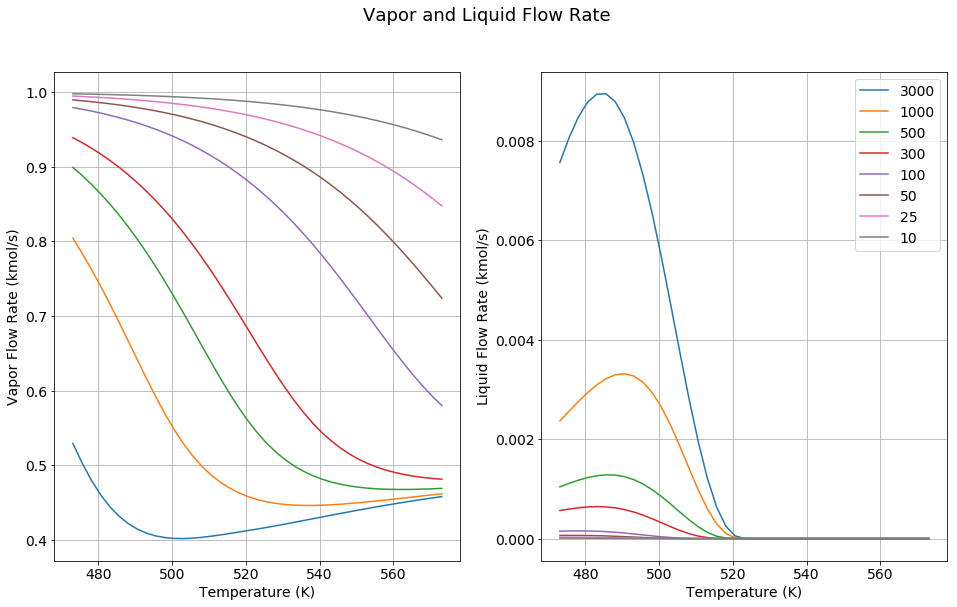

In [30]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,9))
for c in catrange:
    ax1.plot(Trange,rf_data_master[c]['V'])
ax1.set_ylabel('Vapor Flow Rate (kmol/s)',fontsize=14)
ax1.set_xlabel('Temperature (K)',fontsize=14)
ax1.tick_params(labelsize=14)
ax1.grid()

for c in catrange:
    ax2.plot(Trange,rf_data_master[c]['L'])
ax2.set_ylabel('Liquid Flow Rate (kmol/s)',fontsize=14)
ax2.set_xlabel('Temperature (K)',fontsize=14)
ax2.tick_params(labelsize=14)
ax2.grid()

ax2.legend(catrange,fontsize=14)
fig.suptitle('Vapor and Liquid Flow Rate',fontsize=18)

plt.show()

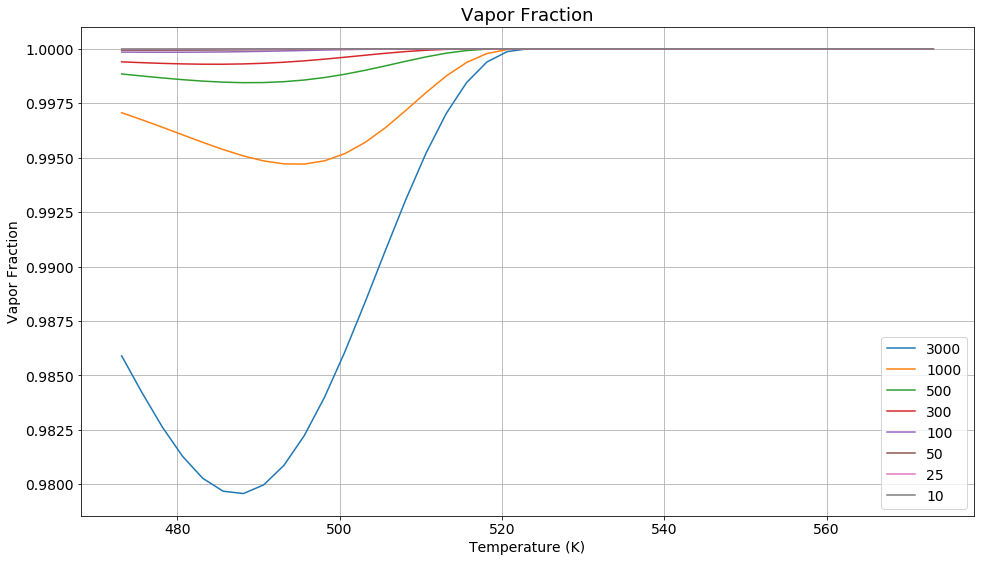

In [31]:
fig, ax1 = plt.subplots(figsize=(16,9))
for c in catrange:
    ax1.plot(Trange,np.divide(rf_data_master[c]['V'],np.add(rf_data_master[c]['V'],rf_data_master[c]['L'])))
ax1.set_ylabel('Vapor Fraction',fontsize=14)
ax1.set_xlabel('Temperature (K)',fontsize=14)
ax1.tick_params(labelsize=14)
ax1.legend(catrange,fontsize=14)
ax1.set_title('Vapor Fraction',fontsize=18)
ax1.grid()
plt.show()

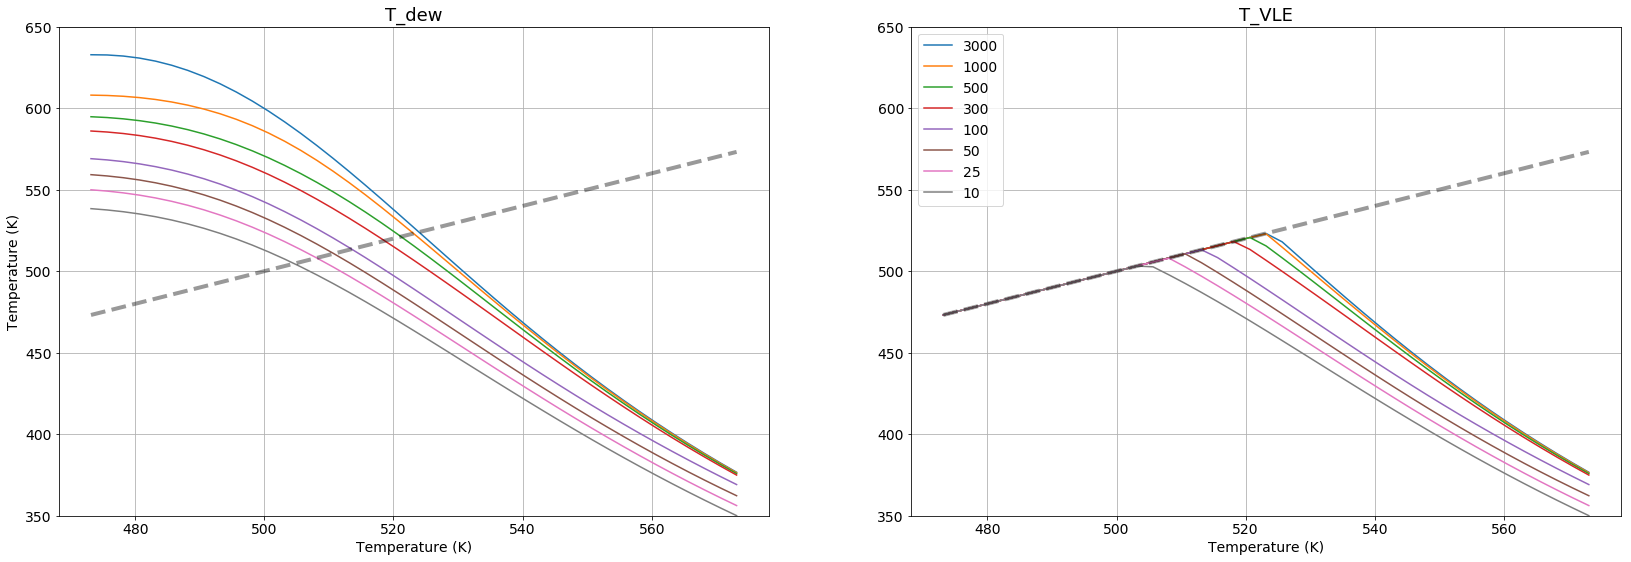

In [32]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(28,9))
for c in catrange:
    ax1.plot(Trange,rf_data_master[c]['T_dew'])
ax1.plot(Trange,rf_data_master[c]['T'],'k--',linewidth=4,alpha=0.4)
ax1.set_ylabel('Temperature (K)',fontsize=14)
ax1.set_xlabel('Temperature (K)',fontsize=14)
ax1.set_ylim(350,650)
ax1.tick_params(labelsize=14)
ax1.grid()

for c in catrange:
    ax2.plot(Trange,rf_data_master[c]['T_VLE'])
# ax2.set_ylabel('Liquid Flow Rate (kmol/s)',fontsize=14)
ax2.set_xlabel('Temperature (K)',fontsize=14)
ax2.set_ylim(350,650)
ax2.tick_params(labelsize=14)
ax2.grid()

ax2.legend(catrange,fontsize=14)
ax2.plot(Trange,rf_data_master[c]['T'],'k--',linewidth=4,alpha=0.4)
ax1.set_title('T_dew',fontsize=18)
ax2.set_title('T_VLE',fontsize=18)

plt.show()